# SGD Inference Implementation
### This notebook provides a simple implementation of a bivariate linear regression setup for the batch-means and Lugsail estimator, using averaged SGD as proposed by Singh et al. (2023). 
### The method is discussed in section 2.3 of the report. Detailed derivations are given in appendix A. 


In [1]:
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import inv
from scipy.stats import chi2, multivariate_normal, norm

## Data generating process setup
Assume the relationship $ y=2x_{1} +0.5x_{2} +\epsilon $, with independent $ x_{1} ,x_{2} \sim U( -5,5)$ and $ \epsilon \sim N\left( 0,0.1^{2}\right)$. Define the loss function as 

\begin{equation}
f:\mathbb{R}^{2} \times \mathbb{R}^{2}\rightarrow \mathbb{R} ,f( \theta ,\zeta ) =\frac{1}{2}\left( y-x^{T} \theta \right)^{2},\tag{1}
\end{equation}

with gradient 

\begin{equation}
\nabla f\left( \theta^{*} ,\zeta \right) = -\left( y-x^{T} \theta ^{*}\right) x. \tag{2}
\end{equation}

The true minimizer is given by $\theta^{*}=(2,0.5)^T$.

In [2]:
# Objective function (1)
def f(x, y, theta):
    """
    Calculate the convex quadratic loss function.

    Args:
        x (numpy.ndarray): Input feature matrix.
        y (numpy.ndarray): Output target vector.
        theta (numpy.ndarray): Parameter vector.

    Returns:
        float: The loss calculated using the convex quadratic formula.
    """
    y_hat = np.dot(x, theta) # Predict y with parameters obtained via SGD method

    loss = 0.5 * (y - y_hat)**2 # Calculate sum over all losses

    return loss # Return average loss


# Gradient of objective function (2)
def gradf(x, y, theta):
    """
    Compute the gradient of the loss function with respect to theta.

    Args:
        x (numpy.ndarray): Input feature matrix.
        y (numpy.ndarray): Output target vector.
        theta (numpy.ndarray): Parameter vector.

    Returns:
        numpy.ndarray: The gradient of the loss function with respect to theta.
    """
    y_hat = np.dot(x, theta) # Predict y using a linear model
    error = y - y_hat
    
    return -np.dot(x.T, error) # Compute and return the gradient


# Sample points for simulation w.r.t. distributional assumptions
def sample_points(n, a=-5, b=5, mu=0, sigma=0.1):
    """
    Generate sample data points for the convex quadratic loss function.

    Args:
        n (int): Number of sample points to generate.
        a (float, optional): Lower bound for uniform distribution. Defaults to -5.
        b (float, optional): Upper bound for uniform distribution. Defaults to 5.
        mu (float, optional): Mean for the Gaussian noise. Defaults to 0.
        sigma (float, optional): Standard deviation for the Gaussian noise. Defaults to 0.1.

    Returns:
        pandas.DataFrame: A DataFrame containing the generated sample points.
    """
    np.random.seed(0) # Set the random seed for reproducibility

    x1 = np.random.uniform(a, b, n) # Generate uniformly distributed x1 and x2
    x2 = np.random.uniform(a, b, n)
    err = np.random.normal(mu, sigma, n) # Generate Gaussian noise

    # Compute the target variable y based on a predefined linear relationship
    y = 2 * x1 + 0.5 * x2 + err

    # Return the sample points as a DataFrame
    return pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

## Covariance definition
Define the expected loss as 
\begin{equation}
F( \theta ) =\mathbb{E}_{\Pi }\left[\frac{1}{2}\left( y-x^{T} \theta \right)^{2}\right]. \tag{3}
\end{equation}

The Hessian is then given by

\begin{equation}
\nabla ^{2} F( \theta ) =\begin{pmatrix}
\frac{1}{12}( b-a)^{2} & 0\\
0 & \frac{1}{12}( b-a)^{2}
\end{pmatrix} =A. \tag{4}
\end{equation} 

Further, it holds that 

\begin{equation} 
S=\mathbb{E}_{\Pi }\left(\left[ \nabla f\left( \theta ^{*} ,\zeta \right)\right]\left[ \nabla f\left( \theta ^{*} ,\zeta \right)\right]^{T}\right) =Var_{\Pi }( \epsilon ) A. \tag{5}
\end{equation} 

Therefore, one obtains the true covariance matrix 

\begin{equation} 
\Sigma =A^{-1} SA^{-1} =Var_{\Pi }( \epsilon ) A^{-1} =0.1^{2}\begin{pmatrix} \tag{6}
12/100 & 0\\
0 & 12/100
\end{pmatrix}.
\end{equation} 

In [3]:
# True Hessian matrix (3)
def hessian(a=-5, b=5):
    """
    Calculate the Hessian matrix for independent uniformly distributed variables centered at 0.

    Args:
        a (float, optional): Lower bound for uniform distribution. Defaults to -5.
        b (float, optional): Upper bound for uniform distribution. Defaults to 5.

    Returns:
        numpy.ndarray: A 2x2 diagonal matrix representing the Hessian.
    """
    # Calculate variance assuming x1, x2 are independent, centered at 0 and uniformly distributed
    var = (1/12) * (b - a)**2
    # Create a 2x2 diagonal matrix with var on the diagonals
    A = np.diag([var, var])

    return A


# True S matrix (5), corresponding to outer product of expected gradient at optimal theta
def S_matrix(a=-5, b=5, sigma=0.1, hessian=hessian):
    """
    Compute the S matrix which corresponds to the scaled Hessian.

    Args:
        a (float, optional): Lower bound for uniform distribution. Defaults to -5.
        b (float, optional): Upper bound for uniform distribution. Defaults to 5.
        sigma (float, optional): Standard deviation for the Gaussian noise. Defaults to 0.1.
        hessian (function): Function to compute the Hessian matrix. Defaults to hessian.

    Returns:
        numpy.ndarray: Scaled Hessian matrix.
    """
    A = hessian(a, b) # Compute true Hessian
    var = sigma**2 # Compute variance
    S = var * A
    return S


# True covariance matrix as shown in equation (6)
def Sigma_fun(a=-5, b=5, sigma=0.1, hessian=hessian, S_matrix=S_matrix):
    """
    Compute true Sigma matrix.

    Args:
        a (float, optional): Lower bound for uniform distribution. Defaults to -5.
        b (float, optional): Upper bound for uniform distribution. Defaults to 5.
        sigma (float, optional): Standard deviation for the Gaussian noise. Defaults to 0.1.
        hessian (function): Function to compute the Hessian matrix. Defaults to hessian.
        S_matrix (function): Function to compute the S matrix. Defaults to S_matrix.

    Returns:
        numpy.ndarray: Sigma matrix calculated as the inverse of Hessian matrix, scaled by S matrix.
    """
    A = hessian(a, b) # Compute true Hessian
    S = S_matrix(a, b, sigma) # Compute true S matrix
    A_inv = inv(A) # Compute inverse of Hessian matrix
    Sigma_matrix = A_inv @ S @ A_inv # Compute true covariance matrix

    return Sigma_matrix

## Validate theoretical quantities with large sample approximations

In [21]:
# Function to validate theoretical results of Hessian (4) with simulation 
def hessian_approx(n, sample_points=sample_points, hessian=hessian):
    """
    Approximate the Hessian matrix using a sample of points.

    Args:
        n (int): Number of points to sample.
        sample_points (callable): Function to generate sample points.

    Returns:
        numpy.ndarray: Approximated Hessian matrix.

    Raises:
        ValueError: If the approximated Hessian is not positive semi-definite.
    """
    A = hessian()
    df = sample_points(n)
    # Sum over all outer products and then average with the number of points n
    sum_outer_products = np.sum([np.outer(np.array([row['x1'], row['x2']]), 
                                          np.array([row['x1'], row['x2']])) 
                                          for _, row in df.iterrows()], axis=0)
    A_approx = sum_outer_products / n

    # Validate that the covariance matrix is positive semi-definite
    if np.any(np.linalg.eigvals(A_approx) < 0):
        raise ValueError("A_approx is not positive semi-definite")

    # Validate that the approximated Hessian is reasonably close to the true Hessian
    if (np.linalg.norm(A - A_approx, ord='fro') > 1e-2):
        raise ValueError("The Hessian approximation is not sufficient")
    
    return A_approx


# Empirical approximation of S matrix (5)
def S_approx(n, sigma=0.1, hessian_approx=hessian_approx, hessian=hessian):
    """
    Approximate S using the Hessian approximation scaled by sigma^2.

    Args:
        n (int): Number of sample points to estimate the Hessian.
        sigma (float, optional): Standard deviation for the Gaussian noise. Defaults to 0.1.
        hessian_approx (function): Function to compute the approximated Hessian matrix. Defaults to hessian_approx.

    Returns:
        numpy.ndarray: Approximated S matrix.
    """
    A_approx = hessian_approx(n) # Compute Hessian approximation
    var = sigma**2 # Compute variance
    S_approx_matrix = var * A_approx # Compute approximate S matrix

    return S_approx_matrix


# Empirical approximation of Sigma matrix (6)
def Sigma_approx(n, sigma=0.1, hessian_approx=hessian_approx, Sigma_fun=Sigma_fun):
    """
    Approximate Sigma with the inverse of the Hessian approximation scaled by sigma^2.

    Args:
        n (int): Number of sample points to estimate the Hessian.
        sigma (float, optional): Standard deviation for the Gaussian noise. Defaults to 0.1.
        hessian_approx (function): Function to compute the approximated Hessian matrix. Defaults to hessian_approx.
        Sigma_fun (function): Function to compute the true covariance matrix. Defaults to Sigma_fun.

    Returns:
        numpy.ndarray: Approximated S matrix.
    """
    Sigma = Sigma_fun() # Call true covariance matrix
    A_approx = hessian_approx(n) # Compute Hessian approximation
    var = sigma**2 # Compute variance
    A_inv_approx = inv(A_approx) # Compute inverse of Hessian approximation
    Sigma_approx_matrix = var * A_inv_approx # Compute approximate S matrix

    # Validate that the approximated covariance matrix is reasonably close to the true covariance matrix
    if (np.linalg.norm(Sigma - Sigma_approx_matrix, ord='fro') > 1e-2):
        raise ValueError("The Sigma approximation is not sufficient")

    return Sigma_approx_matrix

Recall that $ \Sigma =0.1^{2}\begin{pmatrix}
12/100 & 0\\
0 & 12/100
\end{pmatrix}.$

In [22]:
# Validate theoretical quantities with approximation
Sigma_approx(10000000)

array([[1.20002889e-03, 4.39651158e-07],
       [4.39651158e-07, 1.19973872e-03]])

## Stochastic and mini-batch gradient descent
Let $ \zeta _{i}\overset{iid}{\sim } \Pi $, $ i=1,...,n$. Define $\eta _{i}  >0$ as the learning rate and $ \theta _{0}$ as starting point. 
<br> <br> The $ i^{\text{th}}$ iteration of stochastic gradient descent (SGD) is then given by
\begin{equation}
\theta _{i} =\theta _{i-1} -\eta _{i} \nabla f( \theta _{i-1} ,\zeta _{i}) ,\ i=1,2,...\ . \tag{7}
\end{equation}
Denote by $b_n$ the size of a randomly sampled batch, such that $b_n \leq n$ and let $j \in \{1,...,\tau_k\}$ be the index in the $k^{\text{th}}$ batch. 
<br> <br> Assume $ \eta _{t} =\eta t^{-\alpha } ,\alpha \in ( 0.5,1)$. The mini-batch gradient descent update is then defined as
\begin{equation}
\theta _{t} =\theta _{t-1} -\eta _{t}\frac{1}{b_{n}}\sum _{j=1}^{\tau_k} \nabla f( \theta _{t-1} ,\zeta _{j}), \ t=1,2,...\ . \tag{8}
\end{equation} 

In [14]:
# Perform SGD or mini-batch SGD
def sgd(df, eta, alpha, iterations, err, batch_size, gradf=gradf):
    """
    Function to perform SGD, Mini-batch gradient descent or batch gradient descent.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the dataset with features 'x1', 'x2', and label 'y'.
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        iterations (int): Maximum number of iterations to run SGD.
        err (float): Error threshold for the norm of the gradient, used as a convergence criterion.
        batch_size (int): The size of the batch to be sampled in each iteration of SGD.
        gradf (function): Function to compute the gradient at a given point (x, y, theta).

    Returns:
        path_df (pandas.DataFrame): DataFrame containing the trajectory of theta values during SGD.
        num_iterations (int): Number of iterations taken to converge. Returns total iterations if convergence is not achieved.
    """
    iterations = int(iterations) 
    path = []  # To store the trajectory of theta during SGD
    converged = False  # Flag to indicate if the algorithm has converged
    num_iterations = 0  # To count the number of iterations performed
    theta = np.array([-4.0, 4.0])  # Starting point for theta

    np.random.seed(0)  # Fixing the random seed for reproducible random selections

    for i in range(iterations):
        batch = df.sample(batch_size)
        avg_grad = np.array([0, 0], dtype=float)  # Initialize average gradient

        # Calculate the average gradient over the selected batch
        for index, point in batch.iterrows():
            x = np.array([point['x1'], point['x2']])  # Construct the x array from the batch
            y = point['y']  # Extract the y value
            grad = gradf(x, y, theta)  # Compute gradient at the point
            avg_grad += grad  # Accumulate gradients

        avg_grad /= batch_size  # Compute the average gradient

        # Check if the gradient norm is smaller than the error threshold
        if np.linalg.norm(avg_grad) < err:
            converged = True
            num_iterations = i + 1
            break  # Exit the loop if convergence criteria met

        # Calculate learning rate for this iteration
        eta_t = eta * (i + 1) ** (-alpha)

        # Update the point using the average gradient
        theta -= eta_t * avg_grad
        path.append(tuple(theta))  # Add the new theta to the path
    
    # Print the convergence status
    if converged:
        print(f"The algorithm converged after {num_iterations} iterations.")
    else:
        print(f"The algorithm did not converge after {iterations} iterations.")

    # Convert the path to a DataFrame and return
    path_df = pd.DataFrame(path, columns=['theta1', 'theta2'])
    return path_df, num_iterations

In [15]:
# Plot SGD trajectory on loss surface
def sgd_plot(ax, eta, alpha, iterations, err, batch_size, total_points, sample_points=sample_points, sgd=sgd, f=f):
    """
    Plot the optimization path of SGD on a loss surface.

    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axis to plot on.
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        iterations (int): Maximum number of iterations to run SGD.
        err (float): Error threshold for the norm of the gradient, used as a convergence criterion.
        batch_size (int): The size of the batch to be sampled in each iteration of SGD.
        total_points (int): Total number of points to sample.
        sample_points (function): Function to generate sample data points. Defaults to sample_points.
        sgd (functiom): Stochastic Gradient Descent function. Defaults to sgd.
        f (function): Convex quadratic loss function. Defaults to f.

    Returns:
        None: The function creates a plot and does not return anything.
    """
    # Sample points from the function
    df = sample_points(total_points)

    # Perform SGD to get the path and number of iterations
    path_df, num_iter = sgd(df, eta, alpha, iterations, err, batch_size)

    # Set plotting style to default
    plt.style.use('default')
    
    # Calculate a representative point and the loss at the minimum theta
    representative_x = np.array([np.mean(df['x1']), np.mean(df['x2'])])
    representative_y = np.mean(df['y'])
    min_theta = np.array([2, 0.5])
    loss_at_min = f(representative_x, representative_y, min_theta)

    # Generate meshgrid for theta1 and theta2
    theta1 = np.linspace(-5, 5, 50)
    theta2 = np.linspace(-5, 5, 50)
    theta1, theta2 = np.meshgrid(theta1, theta2)

    # Use a sample of x and y values to plot the loss surface
    sample_df = df.sample(50)  # Sample a subset of points for calculation
    z_surface = np.array([np.mean([f(np.array([point['x1'], point['x2']]), point['y'], [theta1_i, theta2_i]) 
                                   for _, point in sample_df.iterrows()])
                                   for theta1_i, theta2_i in zip(np.ravel(theta1), np.ravel(theta2))]).reshape(theta1.shape)

    # Plot the surface
    ax.plot_surface(theta1, theta2, z_surface, cmap='viridis', alpha=0.6)

    # Plot the path of SGD
    ax.plot(path_df['theta1'], path_df['theta2'], color='r', marker='o', markersize=2, label='$\\theta_i$')
        # Mark the minimum point on the surface
    ax.scatter(*min_theta, loss_at_min, color='black', marker='*', s=150, label='$\\theta_{min}$')

    # Set axis labels and title
    ax.set_xlabel('$\\theta_1$', fontsize=8)
    ax.set_ylabel('$\\theta_2$', fontsize=8)
    ax.set_zlabel('L', fontsize=8)
    ax.set_title(f"Iterations={num_iter}, $b_n$={batch_size}, $\\eta$={eta} and $\\alpha$={alpha}.", fontsize=10)

    # Create custom legend handles
    min_handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=2, label='$\\theta^*$')
    path_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=2, label='$\\theta_i$')

    # Add the legend with custom handles
    ax.legend(handles=[min_handle, path_handle], loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

## Averaged SGD and batch-means
Recall the $ i^{\text{th}}$ iteration of stochastic gradient descent (SGD) is given by
\begin{equation}
\theta _{i} =\theta _{i-1} -\eta _{i} \nabla f( \theta _{i-1} ,\zeta _{i}) ,\ i=1,2,...\ . \tag{9}
\end{equation}
Define the averaged SGD estimate as
\begin{equation}
\hat{\theta }_{n} :=n^{-1}\sum\nolimits _{i=1}^{n} \theta _{i} \tag{10}
\end{equation}
Denote by $b_n$ the batch-size and let $a_n=K=n/b_n$ be the number of batches.  
<br> <br> Let $ \tau _{k} =\sum\nolimits _{j=1}^{k} b_{n}$ be the ending index of the $k^{\text{th}}$ batch, $k=1,...,K$. Assume $ \eta _{i} =\eta i^{-\alpha } ,\alpha \in ( 0.5,1)$. Denote the mean vector of batch $ k$ by
\begin{equation}
\overline{\theta }_{k} =b_{n}^{-1}\sum\nolimits _{i=\tau _{k-1} +1}^{\tau _{k}} \theta _{i}. \tag{11}
\end{equation} 

In [16]:
# Perform ASGD and batch-means SGD
def batch_means_sgd(eta, alpha, total_points, burn_in, K, sample_points=sample_points, gradf=gradf):
    """
    Perform batch-means SGD to obtain batch-means and ASGD estimator.
    
    Args:
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        sample_points (function): Function to generate sample data points. Defaults to sample_points.
        gradf (function): Function to compute the gradient at a given point (x, y, theta).

    Returns:
        tuple: A tuple containing two pandas DataFrames. 
        (`path_df`) contains the path of cumulated and scaled batch-means. 
        (`means_df`) contains the batch means.

    Raises:
        ValueError: If K does not correspond to the number of batch means or if
        the last tuple in path is not equal to the average of batch_means.
    """
    # Sample data points
    np.random.seed(0)  # Fixing the random seed for reproducible random selections

    df = sample_points(total_points) # Generate sample dataframe

    # Initialize lists to store gradients and batch means
    theta_hat_grads = [] # gradients used to calculate batch-mean
    batch_means = [] # store batch-means
    path = [] # cumulated batch-means
    theta = np.array([-2.0, 1.5])
    b_n = (total_points - burn_in) // K

    # Initialize cumulative sum
    cumulative_sum = np.array([0.0, 0.0])

    # Iterate over each data point
    for index, point in df.iterrows():
        x = np.array([point['x1'], point['x2']])
        y = point['y'] 
        grad = gradf(x, y, theta)

        # Calculate diminishing learning rate
        eta_t = eta * (index + 1) ** (-alpha)

        # Update estimates
        theta -= eta_t * grad

        # Store estimates after burn-in period
        if index >= burn_in:
            theta_hat_grads.append(np.copy(theta))

        # Calculate and store batch means
        if index >= burn_in and (index - burn_in + 1) % (b_n) == 0:
            batch_mean = tuple(sum(x) / len(theta_hat_grads) for x in zip(*theta_hat_grads))
            batch_means.append(batch_mean)
            theta_hat_grads.clear()  # Reset for next batch

            # Update cumulative sum
            scaled_batch_mean = tuple(s / K for s in batch_mean)
            cumulative_sum = tuple(map(sum, zip(cumulative_sum, scaled_batch_mean)))
            path.append(cumulative_sum)

    # Validate the number of batch means
    if K != len(batch_means):
        raise ValueError("K does not correspond to number of batch means")

    # Validate equality of last path element (ASGD estimator) and average batch mean
    if batch_means:
        avg_batch_mean = tuple(sum(x) / len(batch_means) for x in zip(*batch_means))
        theta_hat = path[-1]
        if not np.allclose(theta_hat, avg_batch_mean, atol=1e-8):
            raise ValueError("The ASGD estimator is not equal to the average of the batch-means")

    # Convert path and means to DataFrames
    path_df = pd.DataFrame(path, columns=['theta1', 'theta2'])
    means_df = pd.DataFrame(batch_means, columns=['theta1', 'theta2'])

    return path_df, means_df

In [17]:
# Plot trajectory of batch-means
def batch_means_plot(ax, eta, alpha, total_points, burn_in, K, sample_points=sample_points, f=f, batch_means_sgd=batch_means_sgd):
    """
    Plot trajectory of batch-means and ASGD estimator on loss surface.
    
    Args:
        ax (matplotlib.axes.Axes): The axes object where the plot will be drawn.
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        sample_points (functionl): Function to generate sample data points. Defaults to sample_points.
        f (function): Convex quadratic loss function. Defaults to f.
        batch_means_sgd (function): Function that performs batch-means SGD.

    Note:
        The function does not return anything. It modifies the provided axes object
        with the surface and path plot of the batch means SGD.
    """
    # Perform batch means SGD and obtain the path and means DataFrames
    df = sample_points(total_points)
    path_df, means_df = batch_means_sgd(eta, alpha, total_points, burn_in, K)

    # Compute the batch size
    b_n = (total_points - burn_in) // K

    # Set plot style
    plt.style.use('default')

    representative_x = np.array([np.mean(df['x1']), np.mean(df['x2'])])
    representative_y = np.mean(df['y'])
    min_theta = np.array([2, 0.5])
    theta_hat = np.array([path_df.iloc[-1]['theta1'], path_df.iloc[-1]['theta2']])
    loss_at_min = f(representative_x, representative_y, min_theta)
    loss_theta_hat = f(representative_x, representative_y, theta_hat)

    # Generate meshgrid for theta1 and theta2
    theta1 = np.linspace(-5, 5, 50)
    theta2 = np.linspace(-5, 5, 50)
    theta1, theta2 = np.meshgrid(theta1, theta2)
    sample_df = df.sample(50)  # Sample a subset of points for calculation
    z_surface = np.array([np.mean([f(np.array([point['x1'], point['x2']]), point['y'], [theta1_i, theta2_i]) 
                                   for _, point in sample_df.iterrows()]) 
                                   for theta1_i, theta2_i in zip(np.ravel(theta1), np.ravel(theta2))]).reshape(theta1.shape)
    ax.plot_surface(theta1, theta2, z_surface, cmap='viridis', alpha=0.6)

    # Plot the path of the batch means on the surface
    ax.plot(means_df['theta1'], means_df['theta2'], color='r', marker='o', markersize=2, label='Batch-means')

    # Mark the minimum and estimated points on the plot
    ax.scatter(*min_theta, loss_at_min, color='black', marker='*', s=150, label='$\\theta_{min}$')
    ax.scatter(*theta_hat, loss_theta_hat, color='green', marker='+', s=150, label='$\hat{\\theta}_n$')

    # Set axis labels and title
    ax.set_xlabel('$\\theta_1$', fontsize=8)
    ax.set_ylabel('$\\theta_2$', fontsize=8)
    ax.set_zlabel('z', fontsize=8)
    ax.set_title(f"n={total_points}, burn-in={burn_in}, K={K}, $b_n$={b_n}, $\\eta$={eta} and $\\alpha$={alpha}", fontsize=10)

    # Create custom legend handles
    min_handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=2, label='$\\theta^*$')
    est_handle = mlines.Line2D([], [], color='green', marker='+', linestyle='None', markersize=2, label='$\hat{\\theta}_n$')
    path_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=2, label='$\overline{\\theta}_k$')

    # Add the legend with custom handles at the top right outside of the plot
    ax.legend(handles=[min_handle, est_handle, path_handle], loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

## Batch-means estimator

For $\hat{\theta }_{n} :=n^{-1}\sum\nolimits _{i=1}^{n} \theta _{i}$ and $\overline{\theta }_{k} =b_{n}^{-1}\sum\nolimits _{i=\tau _{k-1} +1}^{\tau _{k}} \theta _{i}$, let again $ b_{n}$ for all $ k$ and $ a_{n} :=K=[ n/b_{n}]$ be the number of batches. The equal batch-means estimator then is defined as
\begin{equation}
\hat{\Sigma }_{b_{n}} =a_{n}^{-1}\sum _{k=1}^{a_{n}} b_{n}(\overline{\theta }_{k} -\hat{\theta }_{n})(\overline{\theta }_{k} -\hat{\theta }_{n})^{T} =\frac{b_{n}}{a_{n}}\sum _{k=1}^{a_{n}}\overline{\theta }_{k}\overline{\theta }_{k}^{T} -b_{n}\hat{\theta }_{n}\hat{\theta }_{n}^{T}. \tag{12}
\end{equation}
The bias-corrected Lugsail estimator is
\begin{equation}
\hat{\Sigma }_{L,b_{n}} =2\hat{\Sigma }_{2b_{n}} -\hat{\Sigma }_{b_{n}}. \tag{13}
\end{equation}

In [18]:
# Function to compute the batch-means estimator and Lugsail estimator 
def batch_means_estimator(eta, alpha, total_points, burn_in, K, batch_means_sgd=batch_means_sgd):
    """
    Compute batch-means estimator and Lugsail covariance by using adjacent batch-means.
    
    Args:
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        batch_means_sgd (function): Function that performs batch-means SGD.

    Returns:
        tuple: A tuple containing the last point of the SGD path (`theta_hat`),
        corresponding to the ASGD estimator, the batch-means estimator of the ASGD 
        estimator, (`theta_covariance`), and the Lugsail covariance estimate 
        (`lugsail_covariance`).

    Raises:
        ValueError: If the computed covariance estimate is not positive semi-definite.
    """
    # Perform batch means SGD and obtain the path and means DataFrames
    path_df, means_df = batch_means_sgd(eta, alpha, total_points, burn_in, K)

    # Initialize lists to store outer products
    outer_products = [] # Store outer products for batch-means estimator
    outer_products_l = []# Store outer products of adjacent batch-means

    # Get the last point of the SGD path
    #theta_hat = path_df_hat.iloc[-1].to_numpy()
    theta_hat = path_df.iloc[-1].to_numpy()
    a_n = K
    b_n = (total_points - burn_in) // K

    # Compute outer products for each batch mean
    for i in range(len(means_df)):
        mean = means_df.iloc[i].to_numpy()
        outer_product = np.outer(mean, mean)
        outer_products.append(outer_product)

    # Calculate the covariance matrix
    t1 = (b_n / a_n) * np.sum(outer_products, axis=0)
    t2 = b_n * np.outer(theta_hat, theta_hat)
    theta_covariance = t1 - t2

    # Use stored batch-means to calculate Lugsail estimator by combining adjacent batch-means
    for i in range(len(means_df) // 2):
        j = 2 * i
        mean = (means_df.iloc[j].to_numpy() + means_df.iloc[j + 1].to_numpy()) / 2
        outer_product = np.outer(mean, mean)
        outer_products_l.append(outer_product)

    t1_l = ((2 * b_n) / (K // 2)) * np.sum(outer_products_l, axis=0)
    t2_l = 2 * t2
    theta_covariance_2bn = t1_l - t2_l
    lugsail_covariance = 2 * theta_covariance_2bn - theta_covariance

    # Validate that the covariance matrix is positive semi-definite
    if np.any(np.linalg.eigvals(theta_covariance) < 0):
        raise ValueError("theta_covariance is not positive semi-definite")
    
    return theta_hat, theta_covariance, lugsail_covariance

## Approximate optimal bound

The batch means estimator satisfies the following approximate bound
\begin{equation}
\mathbb{E} ||\hat{\Sigma }_{b_{n}} -\Sigma ||\lesssim n^{-\alpha /4} +n^{( \beta -1) /2} +n^{( \alpha -\beta ) /2} . \tag{14}
\end{equation}
For choosing $\displaystyle \beta ^{*} =( 1+\alpha ) /2$, the bound simplifies to
\begin{equation}
\mathbb{E} ||\hat{\Sigma }_{b_{n}} -\Sigma ||\lesssim n^{-\alpha /4} +2n^{( \alpha -1) /4} . \tag{15}
\end{equation}


In [19]:
# Check if the Frobenius norm of the estimator and true covariance satisfies the optimal bound (15)
def bound_condition(alpha, n, covariance, Sigma_fun=Sigma_fun):
    """
    Check if the covariance estimates satisfy the approximate optimal bound condition.

    Args:
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        n (int): The sample size after the initial burn-in period.
        covariance (numpy.ndarray): The estimated covariance matrix, i.e., batch-means or Lugsail estimator.
        Sigma_fun (function): Function to compute the true covariance matrix. Defaults to Sigma_fun.

    Returns:
        None: Checks if estimators satisfy the bound.

    Raises:
        ValueError: If the covariance estimates do not satisfy the bound.
    """
    # Calculate the bound based on the provided alpha and n
    bound = n**(-alpha/4) + 2*n**((alpha-1)/4)

    # Compute the Sigma matrix using the provided function
    Sigma = Sigma_fun()

    # Calculate the Frobenius norm of the difference between the covariance and Sigma
    f_norm_theta = np.linalg.norm((covariance - Sigma), 'fro')

    # Calculate the Frobenius norm for the lugsail estimator
    f_norm_lugsail = np.linalg.norm((covariance - Sigma), 'fro')

    # Check if both conditions for the bound are satisfied
    condition1 = bound >= f_norm_theta
    condition2 = bound >= f_norm_lugsail
    
    # Evaluate and communicate the result of the bound condition check
    if not (condition1 and condition2):
        raise ValueError("Covariance estimates do not satisfy the bound")

## Lugsail estimator validation

In [20]:
# Calculate Lugsail estimator from batch-means estimator function and show equivalence
def lugsail_estimator(eta, alpha, total_points, burn_in, K, batch_means_estimator=batch_means_estimator, bound_condition=bound_condition):
    """
    Compute Lugsail estimator using batch_means_estimator function to show equivalence of 
    adjacent batch-means and calculation from scratch of Lugsail estimator.
    Requires that estimators satisfy the optimal bound condition.
    
    Args:
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        batch_means_sgd (function): Function that performs batch-means SGD.
        batch_means_estimator (function): Function that estimates batch-means and Lugsail estimator.

    Returns:
        tuple: A tuple containing the last point of the SGD path (`theta_hat`),
        corresponding to the ASGD estimator, the batch-means estimator of the ASGD 
        estimator, (`theta_covariance`), and the Lugsail covariance estimate 
        (`lugsail_covariance`).

    Raises:
        ValueError: If the lugsail covariances are not approximately equal or if the
        computed lugsail covariance matrix is not positive semi-definite.
    """
    # Estimate covariance using the original batch size
    theta_hat, theta_covariance, lugsail_covariance_bn = batch_means_estimator(eta, alpha, total_points, burn_in, K)

    # Estimate covariance using half the batch size
    _, theta_covariance_2bn, _ = batch_means_estimator(eta, alpha, total_points, burn_in, (K // 2))

    # Compute the lugsail covariance estimate
    lugsail_covariance = 2 * theta_covariance_2bn - theta_covariance

    # Validate that the two lugsail covariances are approximately equal
    if not np.allclose(lugsail_covariance, lugsail_covariance_bn, atol=1e-8):
        raise ValueError("The Lugsail covariances are not equal")

    # Validate that the covariance matrix is positive semi-definite
    if np.any(np.linalg.eigvals(lugsail_covariance) < 0):
        raise ValueError("lugsail_covariance is not positive semi-definite")
    
    n = total_points-burn_in
    
    # Validate if the covariances satisfy the bound
    bound_condition(alpha, n, theta_covariance)
    bound_condition(alpha, n, lugsail_covariance)
    
    return theta_hat, theta_covariance, lugsail_covariance

## Estimator distributions
Denote under some assumptions that 

\begin{equation}
\sqrt{n}\left(\hat{\theta }_{n} -\theta ^{*}\right)\xrightarrow{d} N( 0,\Sigma ) \ \text{as} \ n\rightarrow \infty ,\ \text{where} \ \Sigma =A^{-1} SA^{-1} . \tag{16}
\end{equation}
Correspondingly, the approximate distributions for the batch-means and Lugsail estimator are given by
\begin{equation}
N(\hat{\theta }_{n} ,\hat{\Sigma }_{b_{n}}) \ \text{and} \ N(\hat{\theta }_{n} ,\hat{\Sigma }_{L,b_{n}}) . \tag{17}
\end{equation}

In [23]:
# Plot bivariate Gaussian of estimator distribution
def covariance_plot(ax, eta, alpha, total_points, burn_in, K, covariance_type, lugsail_estimator=lugsail_estimator):
    """
    Plot estimator distribution for different covariance types.
    
    Args:
        ax (matplotlib.axes.Axes): The axes object where the plot will be drawn.
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        covariance_type (string): Covariance typ (batch-means or Lugsail) for the plot.
        lugsail_estimator (function): Function to compute the estiamtors (ASGD, batch-means and Lugsail). Defaults to lugsail_estimator.

    Note:
        The function does not return anything. It modifies the provided axes object
        with the contour plot of the covariance.
    """
    # Extract mean and covariance from the lugsail estimator
    theta_hat, theta_covariance, lugsail_covariance = lugsail_estimator(eta, alpha, total_points, burn_in, K)

    if covariance_type == 'batch-means':
        covariance = theta_covariance
    elif covariance_type == 'Lugsail':
        covariance = lugsail_covariance
    else:
        raise ValueError("Invalid covariance type. Choose 'batch-means' or 'Lugsail'.")

    b_n = (total_points - burn_in) // K

    # Set plot style
    plt.style.use('seaborn-v0_8-dark')

    # Define the grid for the plot
    x, y = np.mgrid[theta_hat[0] - 3*np.sqrt(covariance[0, 0]):theta_hat[0] + 3*np.sqrt(covariance[0, 0]):.01,
                    theta_hat[1] - 3*np.sqrt(covariance[1, 1]):theta_hat[1] + 3*np.sqrt(covariance[1, 1]):.01]
    pos = np.dstack((x, y))

    # Create a multivariate normal distribution with the mean and covariance
    rv = multivariate_normal(theta_hat, covariance)

    # Plot the contour map and get the 0 density color from the colormap
    contour = ax.contourf(x, y, rv.pdf(pos), cmap='viridis', levels=50)
    zero_density_color = contour.cmap(2)

    # Set the background color to match the 0 density region color
    ax.set_facecolor(zero_density_color)

    # Create and customize the colorbar
    cbar = plt.colorbar(contour, ax=ax, label='Density', fraction=0.046, pad=0.04)
    cbar.set_label('Density', fontsize=10)
    cbar.ax.tick_params(labelsize=10)

    # Mark the mean point
    ax.scatter(theta_hat[0], theta_hat[1], color='red', marker='o', label='Mean')

    # Set plot title, axis labels, and custom axes limits
    ax.set_title(f"n={total_points}, burn-in={burn_in}, K={K}, $b_n$={b_n}, $\\eta$={eta} and $\\alpha$={alpha}", fontsize=12)
    ax.set_xlabel('$\\theta_1$', fontsize=10)
    ax.set_ylabel('$\\theta_2$', fontsize=10)
    ax.set_xlim(1.87, 2.13)  # Custom x-axis limits for example
    ax.set_ylim(0.38, 0.62)  # Custom y-axis limits

    # Customize tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Enable grid
    ax.grid(False)

# Comparison of estimator distribution with true distribution

In [26]:
# Plot comparison between estimator distributions and true distribution
def covariance_comparison(fig, eta, alpha, total_points, burn_in, K, covariance_type, lugsail_estimator=lugsail_estimator, Sigma_fun=Sigma_fun):
    """
    Create a plot compare the estimator distribution with the true distribution.

    Args:
        fig (matplotlib.figure.Figure): The matplotlib figure object to plot on.
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        covariance_type (str): Type of covariance to use ('batch-means' or 'Lugsail').
        lugsail_estimator (function): Function to compute the estiamtors (ASGD, batch-means and Lugsail). Defaults to lugsail_estimator.
        Sigma_fun (function): Function to compute the Sigma matrix. Defaults to Sigma_fun.

    Returns:
        matplotlib.figure.Figure: The figure object with the plots.

    Raises:
        ValueError: If an invalid covariance type is provided.
    """
    # Extract mean and covariance from the lugsail estimator
    theta_hat, theta_covariance, lugsail_covariance = lugsail_estimator(eta, alpha, total_points, burn_in, K)
    Sigma = Sigma_fun()
    theta_star = np.array([2.0, 0.5])

    # Select the covariance based on the type
    if covariance_type == 'batch-means':
        covariance = theta_covariance
    elif covariance_type == 'Lugsail':
        covariance = lugsail_covariance
    else:
        raise ValueError("Invalid covariance type. Choose 'batch-means' or 'Lugsail'.")

    # Create a 1x2 grid
    axs = fig.subplots(1, 2)

    # Function to plot on a given axis
    def plot_distribution(ax, mean, covariance):
        """
        Plot a distribution on a given axis.

        Args:
            ax (matplotlib.axes._subplots.AxesSubplot): The axis to plot on.
            mean (numpy.ndarray): The mean vector of the distribution.
            covariance (numpy.ndarray): The covariance matrix of the distribution.
        """
        # Generate grid points for plotting
        x, y = np.mgrid[mean[0] - 3*np.sqrt(covariance[0, 0]):mean[0] + 3*np.sqrt(covariance[0, 0]):.01,
                        mean[1] - 3*np.sqrt(covariance[1, 1]):mean[1] + 3*np.sqrt(covariance[1, 1]):.01]
        pos = np.dstack((x, y))
        rv = multivariate_normal(mean, covariance)
        contour = ax.contourf(x, y, rv.pdf(pos), cmap='viridis', levels=50)
        zero_density_color = contour.cmap(2)
        # Set the background color to match the 0 density region color
        ax.set_facecolor(zero_density_color)
        cbar = plt.colorbar(contour, ax=ax, label='Density', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Density', fontsize=10)
        ax.scatter(mean[0], mean[1], color='red', marker='o', label='Mean')
        ax.grid(False)
        ax.set_xlim(1.87, 2.13)  # Custom x-axis limits for example
        ax.set_ylim(0.38, 0.62) 

    # Plot with theta_hat and selected covariance
    plot_distribution(axs[0], theta_hat, covariance)

    # Plot with theta_star and Sigma
    plot_distribution(axs[1], theta_star, Sigma)

    # Set titles and labels for both plots
    axs[0].set_title(f"$N(\\hat{{\\theta}}_n, \\hat{{\Sigma}}_{{L,b_n}})$, n={total_points}, burn-in={burn_in} K={K}, $\\eta$={eta}, $\\alpha$={alpha}", fontsize=12)
    axs[1].set_title("$N(\\theta^*, \Sigma)$", fontsize=12)
    for ax in axs:
        ax.set_xlabel('$\\theta_1$', fontsize=10)
        ax.set_ylabel('$\\theta_2$', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=10)

# Parameter inference

A $ 100( 1-p) \%$ confidence ellipsoid for joint inference for $ \theta ^{*}$ is given by
\begin{equation}
E_{p} =\left\{\theta \in \mathbb{R}^{d} :(\hat{\theta }_{n} -\theta )^{T}\hat{\Sigma }_{n}^{-1}(\hat{\theta }_{n} -\theta ) \leq \chi _{d,1-p}^{2}\right\}. \tag{18}
\end{equation}
Denote $ \hat{\Sigma }_{n}$ with $ \hat{\Sigma }_{n} =(\hat{\sigma }_{ij})_{i,j=1,...,p}$ as an consistent estimator of $ \Sigma $ and let $ \hat{\theta }_{n} =(\hat{\theta }_{n1} ,...,\hat{\theta }_{nd}) ,\theta ^{*} =\left( \theta _{1}^{*} ,...,\theta _{d}^{*}\right)^{T}$. An asymptotic $ 100( 1-p) \%,\ 0< p< 1$ marginal confidence interval of $ \theta _{i}^{*}$ is

\begin{equation}
\hat{\theta }_{ni} \pm z_{1-p/2}\sqrt{\hat{\sigma }_{ii} /n,}. \tag{19}
\end{equation}
An uncorrected lower bound hyper-rectangular confidence region with at most $ 100( 1-p) \%$ can be defined by taking $ d$ uncorrected intervals, such that 
\begin{equation}
C_{lb}( z_{p/2}) =\prod _{i=1}^{n}\left[\hat{\theta }_{ni} -z_{1-p/2}\sqrt{\hat{\sigma }_{ii} /n} ,\hat{\theta }_{ni} +z_{1-p/2}\sqrt{\hat{\sigma }_{ii} /n,}\right] . \tag{20}
\end{equation}
Applying a Bonferroni correction gives the upper bound
\begin{equation}
C_{ub}( z_{p/2d}) =\prod _{i=1}^{n}\left[\hat{\theta }_{ni} -z_{1-p/2d}\sqrt{\hat{\sigma }_{ii} /n} ,\hat{\theta }_{ni} +z_{1-p/2d}\sqrt{\hat{\sigma }_{ii} /n,}\right] . \tag{21}
\end{equation}

In [27]:
# Calculate confidence regions for estimator as described by equations (18), (20) and (21)
def plot_CI(ax, theta, theta_hat_p, theta_star_p, covariance_matrix, p, n, title, x, y, x_l, x_o, y_l, y_o):
    """
    Plot confidence hyperrectangles and ellipsoidal regions for parameter estimates.

    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to plot on.
        theta (numpy.ndarray): Parameter vector used for confidence regions (ASGD estimate or true parameter).
        theta_hat_p (numpy.ndarray): ASGD estimator.
        theta_star_p (numpy.ndarray): True parameter vector used for comparison.
        covariance_matrix (numpy.ndarray): Covariance matrix used for confidence regions (batch-means, Lugsail or Sigma).
        p (float): Confidence level for the confidence regions.
        n (int): The sample size after the initial burn-in period.
        title (str): Title for the subplot.
        x (numpy.ndarray): Range of x-values for meshgrid.
        y (numpy.ndarray): Range of y-values for meshgrid.
        x_l (float): Lower x-axis limit for the plot.
        x_o (float): Upper x-axis limit for the plot.
        y_l (float): Lower y-axis limit for the plot.
        y_o (float): Upper y-axis limit for the plot.

    Returns:
        None: The function does not return any value but creates a plot on the given axis.
    """
    ci_lb = [] # store lower bound values
    ci_ub = [] # store upper bound values
    d = len(theta)  # Parameter dimension
    z_lb = norm.ppf(1 - p/2)  # Lower bound standard normal quantile
    z_ub = norm.ppf(1 - p/(2*d))  # Upper bound standard normal quantile
    chi_square_value = chi2.ppf(1 - p, d)  # Ellipsoidal quantile of Chi-square distribution
    covariance_matrix_inv = np.linalg.inv((1/n)*covariance_matrix) # Scale covariance matrix by 1/n to obtain meaningful confidence region

    plt.style.use('default')

    # Ellipsoidal region plotting
    X, Y = np.meshgrid(x, y)
    Z = np.array([[(theta-np.array([xi, yi])).T @ covariance_matrix_inv @ (theta - np.array([xi, yi])) 
                   for xi, yi in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
    ax.contour(X, Y, Z, levels=[chi_square_value], colors='violet')
    
    ellipsoid_handle = mlines.Line2D([], [], color='violet', label='Ellipsoid')

    # Confidence interval rectangles
    for i in range(d):
        l_ci_lb = theta[i] - z_lb * np.sqrt(covariance_matrix[i][i] / n)
        u_ci_lb = theta[i] + z_lb * np.sqrt(covariance_matrix[i][i] / n)
        ci_lb.append((l_ci_lb, u_ci_lb))
        l_ci_ub = theta[i] - z_ub * np.sqrt(covariance_matrix[i][i] / n)
        u_ci_ub = theta[i] + z_ub * np.sqrt(covariance_matrix[i][i] / n)
        ci_ub.append((l_ci_ub, u_ci_ub))

    if len(ci_lb) == 2 and len(ci_ub) == 2:
        # Plot rectangles
        for ci, color, label in zip([ci_lb, ci_ub], ['blue', 'red'], ['CI LB', 'CI UB']):
            x_bounds, y_bounds = ci
            rect = patches.Rectangle((x_bounds[0], y_bounds[0]), x_bounds[1] - x_bounds[0], y_bounds[1] - y_bounds[0], 
                                     linewidth=1, edgecolor=color, facecolor='none', label=label)
            ax.add_patch(rect)

        # Mark the estimated point and the minimum point
        ax.scatter(*theta_hat_p, color='orange', marker='o', label='$\hat{\\theta}_n$')
        ax.scatter(*theta_star_p, color='green', marker='o', label='$\\theta^*$')

        # Set labels and title
        ax.set_xlabel('$\\theta_1$', fontsize=8)
        ax.set_ylabel('$\\theta_2$', fontsize=8)
        ax.set_title(title, fontsize=10)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        # Collect handles and labels for the existing plot elements
        handles, labels = ax.get_legend_handles_labels()
        handles.append(ellipsoid_handle)
        ax.legend(handles=handles, fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

        # adjust for example, else plot would be centered around ellipsoid
        ax.set_xlim(x_l, x_o)
        ax.set_ylim(y_l, y_o)

In [28]:
# Plot comparison of estimator confidence regions with true covariance centered at the true theta
def CI_sigma_comparison(eta, alpha, total_points, burn_in, K, p, covariance_type, x, y , x_l, x_o, y_l, y_o, lugsail_estimator=lugsail_estimator, Sigma_fun=Sigma_fun, theta_star=np.array([2.0, 0.5])):
    """
    Compare confidence regions of estimator with true confidence regions.

    Args:
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        p (float): Confidence level for the confidence regions.
        covariance_type (str): Type of covariance to use ('batch-means' or 'Lugsail').
        x (numpy.ndarray): Range of x-values for meshgrid.
        y (numpy.ndarray): Range of y-values for meshgrid.
        x_l (float): Lower x-axis limit for the plot.
        x_o (float): Upper x-axis limit for the plot.
        y_l (float): Lower y-axis limit for the plot.
        y_o (float): Upper y-axis limit for the plot.
        lugsail_estimator (function): Function to compute the estiamtors (ASGD, batch-means and Lugsail). Defaults to lugsail_estimator.
        Sigma_fun (function): Function to compute the true covariance matrix. Defaults to Sigma_fun.
        theta_star (numpy.ndarray, optional): True parameter vector. Defaults to np.array([2.0, 0.5]).

    Returns:
        None: The function plots the comparison of confidence intervals.
    """
    # Extract estimates and covariance matrices from the lugsail estimator
    theta_hat, theta_covariance, lugsail_covariance = lugsail_estimator(eta, alpha, total_points, burn_in, K)
    Sigma = Sigma_fun()
    
    # Set parameters for plotting
    theta_hat_p = theta_hat
    theta_star_p = theta_star

    # Select the appropriate covariance matrix
    if covariance_type == 'batch-means':
        covariance_matrix_1 = theta_covariance
    elif covariance_type == 'Lugsail':
        covariance_matrix_1 = lugsail_covariance
    else:
        raise ValueError("Invalid covariance type. Choose 'batch-means' or 'Lugsail'.")

    # Initialize the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    # Calculate the sample size after burn-in
    n = total_points - burn_in

    # Plot confidence intervals for theta_hat using the selected covariance matrix
    plot_CI(ax1, theta_hat, theta_hat_p, theta_star_p, covariance_matrix_1, p, n, 
            f'n={total_points}, burn-in={burn_in}, K={K}, $\\eta$={eta}, $\\alpha$={alpha} and $p$={p}', x, y, x_l, x_o, y_l, y_o)

    # Plot confidence intervals for theta_star using the Sigma matrix
    plot_CI(ax2, theta_star, theta_hat_p, theta_star_p, Sigma, p, n, 
            f'$\\theta^*$, $\Sigma$, $p$={p}', x, y, x_l, x_o, y_l, y_o)

    # Add a main title to the figure
    fig.suptitle("Lugsail estimator vs true covariance for p=0.05", fontsize=30)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [29]:
# Comparison of confidence regions between batch-means estimator and Lugsail estimator
def CI_batch_lugsail_comparison(eta, alpha, total_points, burn_in, K, p, x, y , x_l, x_o, y_l, y_o, lugsail_estimator=lugsail_estimator, theta_star=np.array([2.0, 0.5])):
    """
    Compare confidence hyperrectangles of batch-means estimator with corresponding Lugsail estimator.

    Args:
        eta (float): Initial learning rate.
        alpha (float): Exponent used for decaying the learning rate in each iteration.
        total_points (int): Total number of points to sample.
        burn_in (int): Number of initial points to discard for ASGD estimator.
        K (int): Number of batches.
        p (float): Confidence level for the confidence regions.
        covariance_type (str): Type of covariance to use ('batch-means' or 'Lugsail').
        x (numpy.ndarray): Range of x-values for meshgrid.
        y (numpy.ndarray): Range of y-values for meshgrid.
        x_l (float): Lower x-axis limit for the plot.
        x_o (float): Upper x-axis limit for the plot.
        y_l (float): Lower y-axis limit for the plot.
        y_o (float): Upper y-axis limit for the plot.
        lugsail_estimator (function): Function to compute the estiamtors (ASGD, batch-means and Lugsail). Defaults to lugsail_estimator.
        Sigma_fun (function): Function to compute the true covariance matrix. Defaults to Sigma_fun.
        theta_star (numpy.ndarray, optional): True parameter vector. Defaults to np.array([2.0, 0.5]).

    Returns:
        None: The function plots the comparison of confidence intervals.
    """
    # Extract estimates and covariance matrices from the lugsail estimator
    theta_hat, theta_covariance, lugsail_covariance = lugsail_estimator(eta, alpha, total_points, burn_in, K)
    
    # Set parameters for plotting
    theta_hat_p = theta_hat
    theta_star_p = theta_star

    # Initialize the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    # Calculate the sample size after burn-in
    n = total_points - burn_in

    # Plot confidence intervals for theta_hat using the selected covariance matrix
    plot_CI(ax1, theta_hat, theta_hat_p, theta_star_p, theta_covariance, p, n, 
            f'n={total_points}, burn-in={burn_in}, K={K}, $\\eta$={eta}, $\\alpha$={alpha} and $p$={p}', x, y, x_l, x_o, y_l, y_o)

    plot_CI(ax2, theta_hat, theta_hat_p, theta_star_p, lugsail_covariance, p, n, 
            f'n={total_points}, burn-in={burn_in}, K={K}, $\\eta$={eta}, $\\alpha$={alpha} and $p$={p}', x, y, x_l, x_o, y_l, y_o)

    # Add a main title to the figure
    fig.suptitle("Batch-means estimator vs Lugsail estimator for p=0.05", fontsize=25)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plotting section
### Optimization trajectory for SGD and ASGD

The algorithm converged after 364 iterations.
The algorithm converged after 932 iterations.
The algorithm converged after 250 iterations.


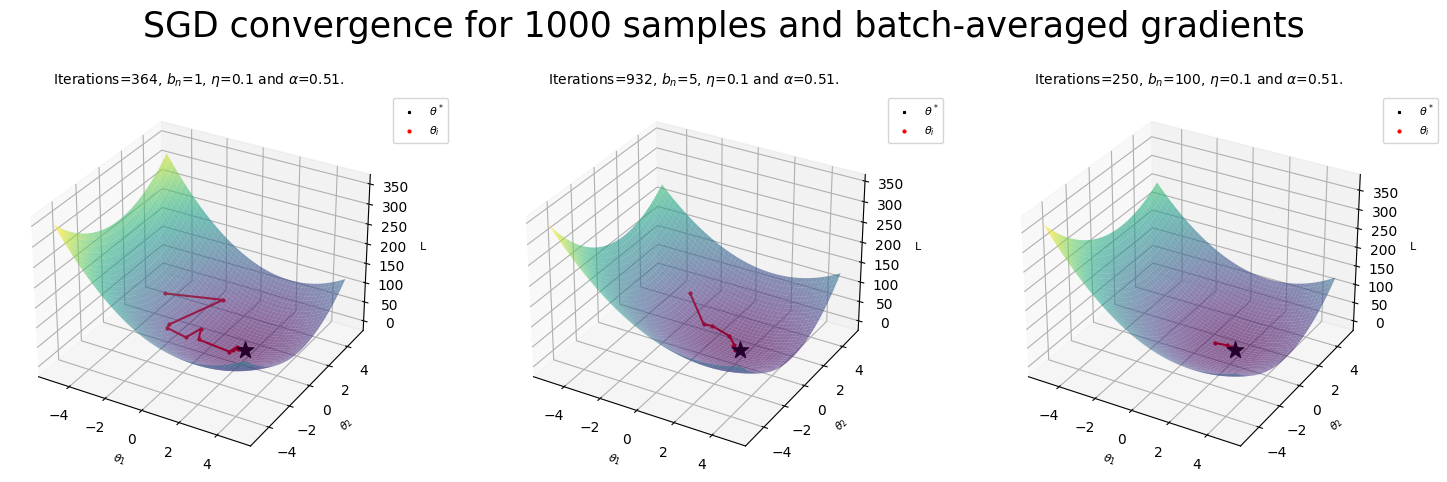

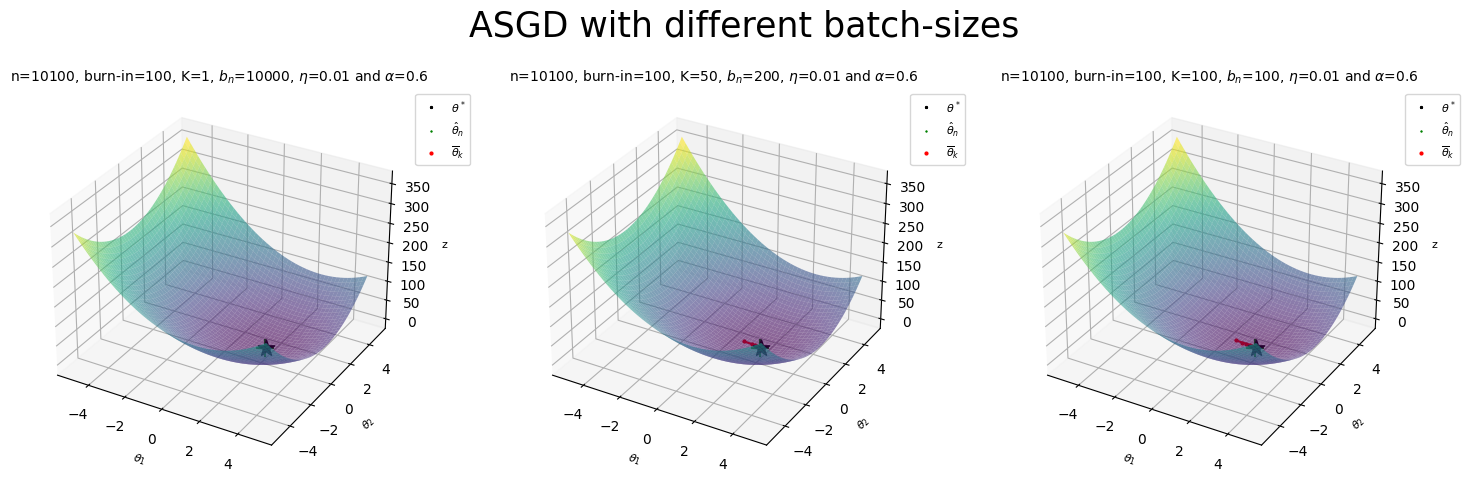

In [30]:
# Create a 4x1 grid for the plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'}, dpi=100)
batch_sizes = [1, 5, 100]
for i, batch_size in enumerate(batch_sizes):
    sgd_plot(axs[i], eta=0.1, alpha=0.51, iterations=20000, err=0.001, batch_size=batch_size, total_points=1000)

# Add a title for the grid of the 4 plots
fig.suptitle("SGD convergence for 1000 samples and batch-averaged gradients", fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'}, dpi=100)

Ks = [1, 50, 100]
for i, k in enumerate(Ks):
    # Learning rate set to eta=0.01 for better visibility in the plot
    batch_means_plot(axs[i], eta=0.01, alpha=0.6, total_points=10100, burn_in=100, K=k)

# Main title
fig.suptitle("ASGD with different batch-sizes", fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
plt.show()

### Batch-means estimator and Lugsail estimator distributions for different values of $K$ 
Please note that the specific batch-size requirement, i.e., $b_n=cn^\beta$ with $\beta \in (0,1), c>0$ was not specifically implemented for simplicity. <br>
However, observe that for $\alpha=0.6$ and corresponding optimal $\beta^*=(1+\alpha)/2=(1+0.6)/2=0.8$, one obtains $b_n=c10000^{0.8}$. The condition is trivially satisfied by fixing an appropriate $c>0$. <br>
Also note that $n=10000$ is the number of observations after some user specified burn-in period $(100)$.

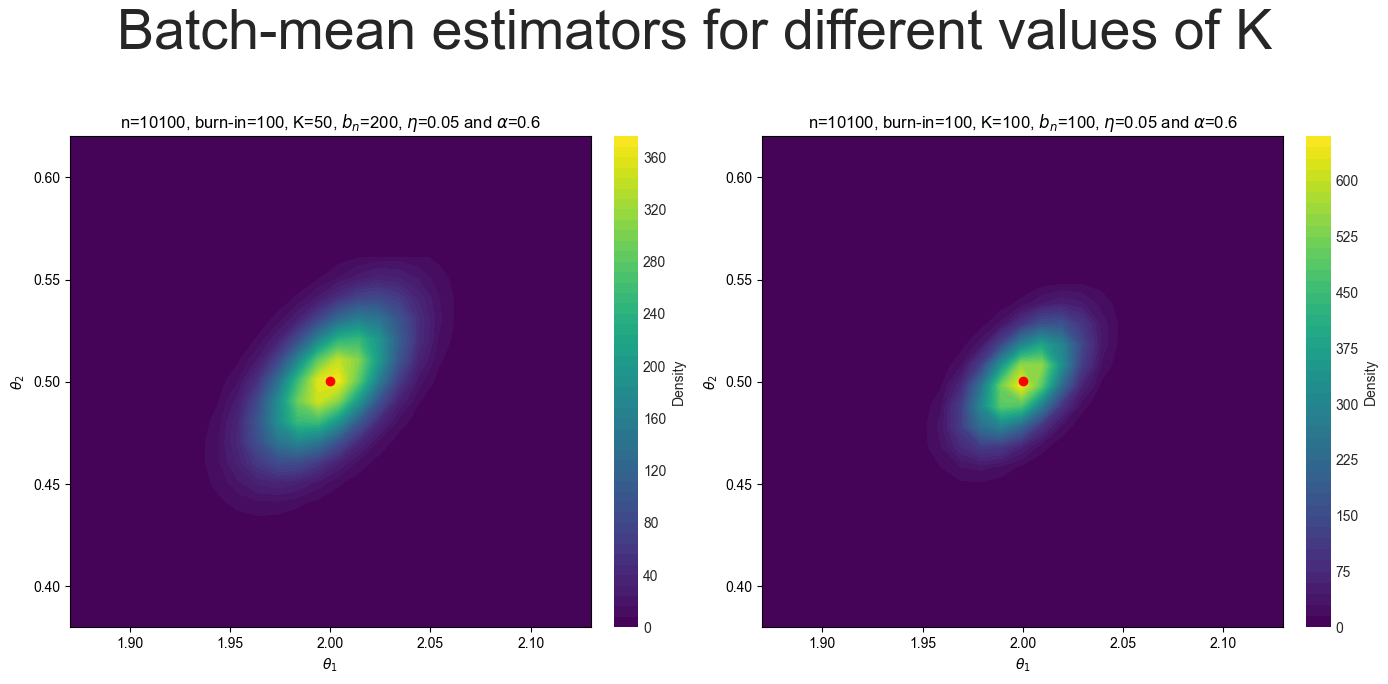

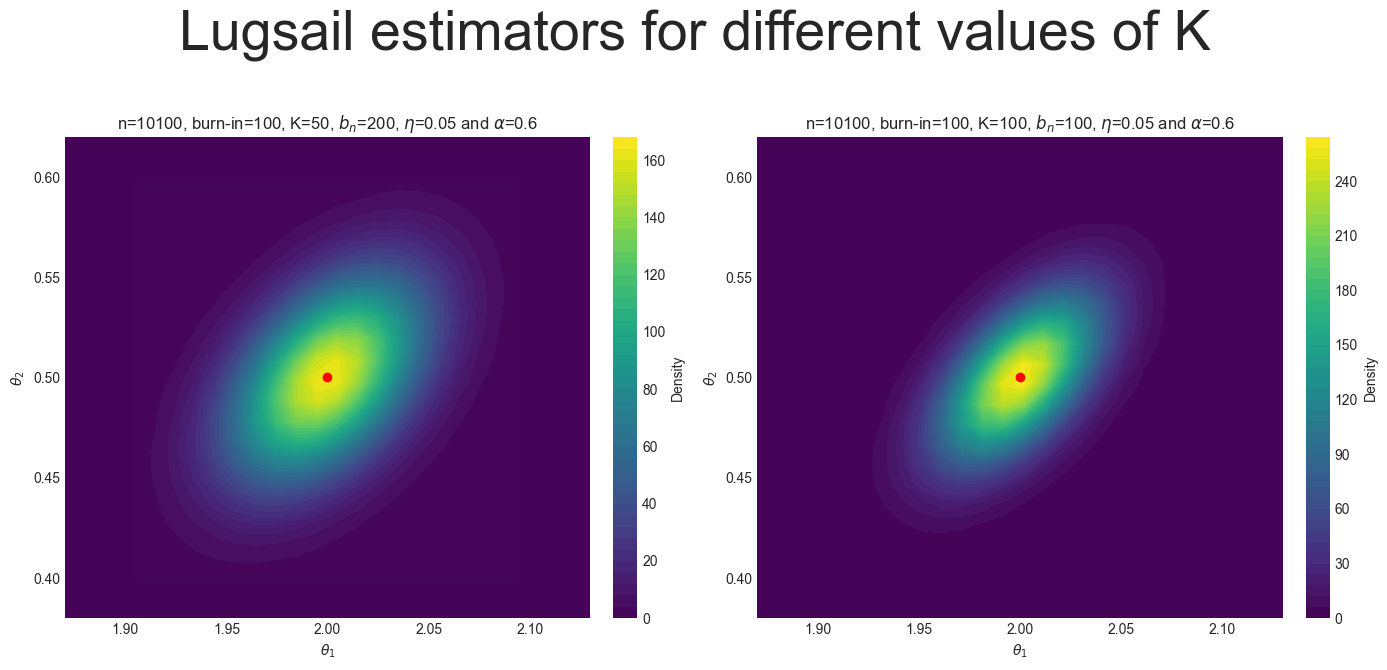

In [31]:
Ks = [50, 100]
fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
for i, K in enumerate(Ks):
    covariance_plot(axs[i], eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=K, covariance_type='batch-means')
fig.suptitle("Batch-mean estimators for different values of K", fontsize=40)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
for i, K in enumerate(Ks):
    covariance_plot(axs[i], eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=K, covariance_type='Lugsail')
fig.suptitle("Lugsail estimators for different values of K", fontsize=40)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Comparison of Lugsail estimator centered at the ASGD estimate with the true distribution

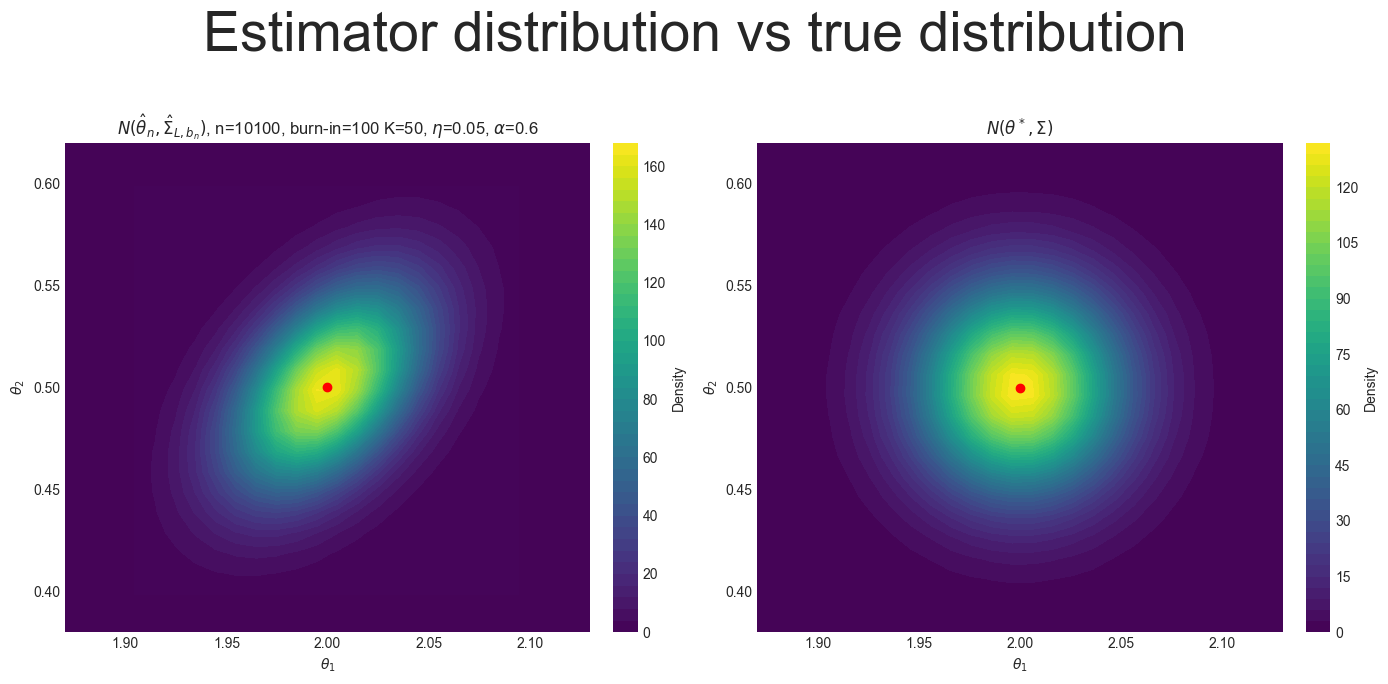

In [32]:
fig = plt.figure(figsize=(14, 7), dpi=100)
covariance_comparison(fig, eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=50, covariance_type='Lugsail')
fig.suptitle("Estimator distribution vs true distribution", fontsize=40)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

### Compairson of batch-means estimator and Lugsail confidence regions for different values of $K$

Recall that a $ 100( 1-p) \%$ confidence ellipsoid for joint inference for $ \theta ^{*}$ is given by
\begin{equation}
E_{p} =\left\{\theta \in \mathbb{R}^{d} :(\hat{\theta }_{n} -\theta )^{T}\hat{\Sigma }_{n}^{-1}(\hat{\theta }_{n} -\theta ) \leq \chi _{d,1-p}^{2}\right\}. \tag{18}
\end{equation}
Also recall $ \hat{\Sigma }_{n}$ with $ \hat{\Sigma }_{n} =(\hat{\sigma }_{ij})_{i,j=1,...,p}$ is an consistent estimator of $ \Sigma $. However, an implementation of this formula does not result in reasonable confidence regions. <br>
To obtain a meaningful confidence Ellipsoid, it is required to scale $ \hat{\Sigma }_{n}$ by $(1/n)$, such that $(1/n) \hat{\Sigma }_{n} =(\hat{\sigma }_{ij})_{i,j=1,...,p}/n$.
<br> <br>
An uncorrected lower bound hyper-rectangular confidence region with at most $ 100( 1-p) \%$ is 
\begin{equation}
C_{lb}( z_{p/2}) =\prod _{i=1}^{n}\left[\hat{\theta }_{ni} -z_{1-p/2}\sqrt{\hat{\sigma }_{ii} /n} ,\hat{\theta }_{ni} +z_{1-p/2}\sqrt{\hat{\sigma }_{ii} /n,}\right] . \tag{20}
\end{equation}
Applying a Bonferroni correction results in the upper bound
\begin{equation}
C_{ub}( z_{p/2d}) =\prod _{i=1}^{n}\left[\hat{\theta }_{ni} -z_{1-p/2d}\sqrt{\hat{\sigma }_{ii} /n} ,\hat{\theta }_{ni} +z_{1-p/2d}\sqrt{\hat{\sigma }_{ii} /n,}\right] . \tag{21}
\end{equation}
Observe that for both confidence hyperrectangle regions, the standard error $\sqrt{\hat{\sigma }_{ii} /n}$ is appropriately scaled.

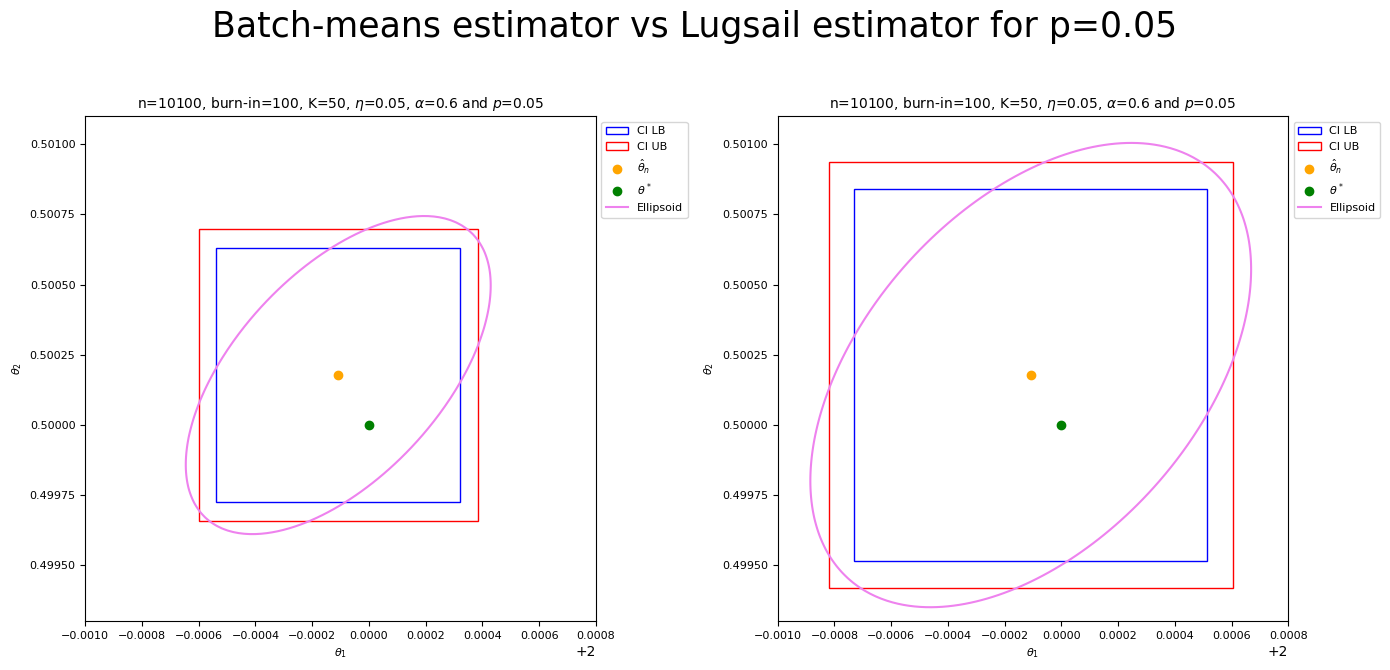

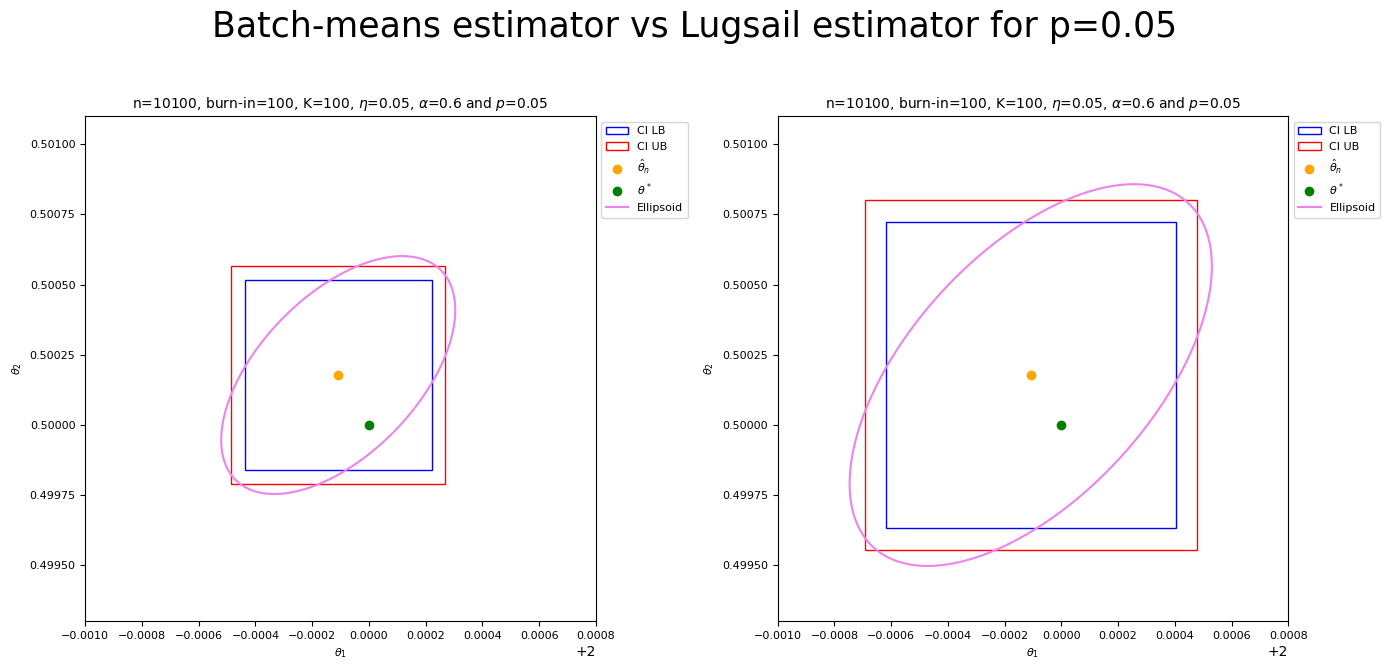

In [34]:
CI_batch_lugsail_comparison(eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=50, p=0.05, 
                            x=np.linspace(1.992, 2.0018, 500), y=np.linspace(0.4986, 0.5012, 500), x_l=1.999, x_o=2.0008, y_l=0.4993, y_o=0.5011)
CI_batch_lugsail_comparison(eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=100, p=0.05, 
                            x=np.linspace(1.992, 2.0018, 500), y=np.linspace(0.4986, 0.5012, 500), x_l=1.999, x_o=2.0008, y_l=0.4993, y_o=0.5011)

### Comparison of Lugsail estimator confidence region with true distribution

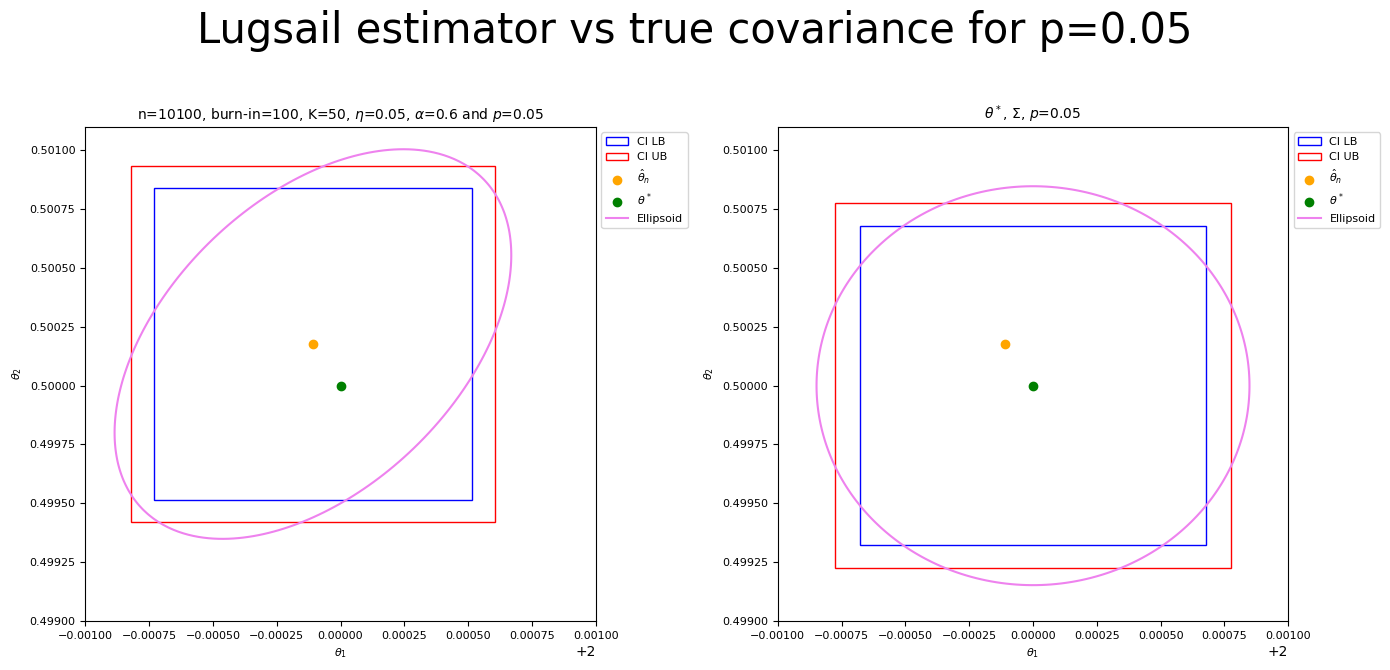

In [35]:
CI_sigma_comparison(eta=0.05, alpha=0.6, total_points=10100, burn_in=100, K=50, p=0.05, covariance_type='Lugsail', 
                    x=np.linspace(1.992, 2.0018, 500), y=np.linspace(0.4986, 0.5012, 500), x_l=1.999, x_o=2.001, y_l=0.499, y_o=0.5011)